In [28]:
import os
from openai import OpenAI

# Test Fireworks client connection
client = OpenAI(
    api_key=os.environ.get("FIREWORKS_API_KEY"),
    base_url="https://api.fireworks.ai/inference/v1"
)

print("Client loaded successfully.")


Client loaded successfully.


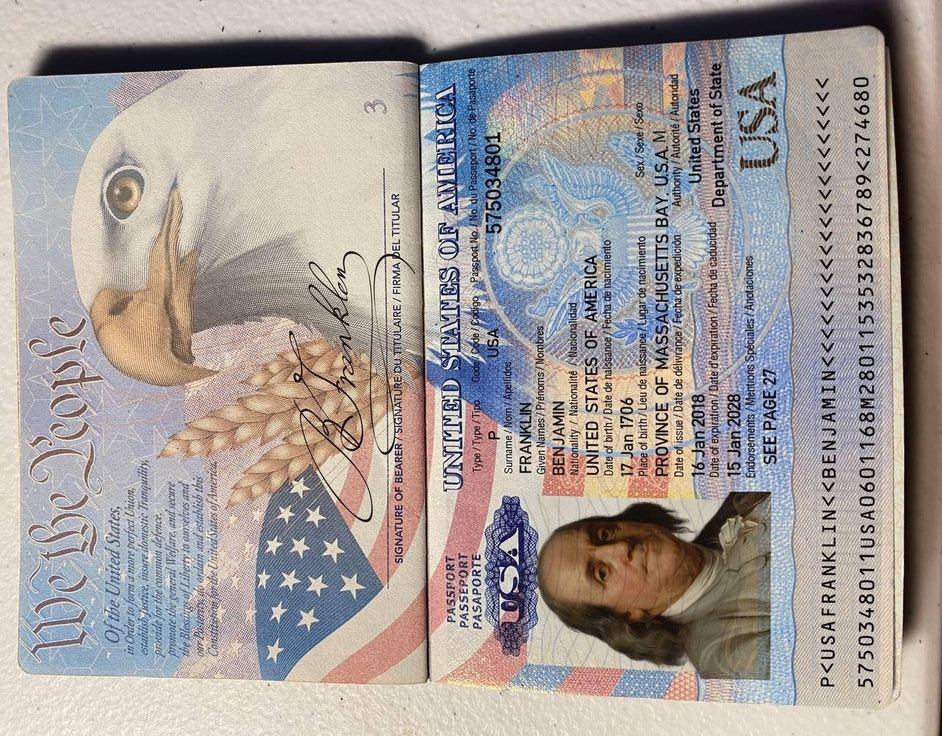

In [29]:
import os
from PIL import Image

image_path = "/Users/ram/Desktop/FireWorks/Images/passport-2.jpg"

# Load & display image
img = Image.open(image_path)
img


In [30]:
import base64

def encode_image_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

image_b64 = encode_image_to_base64(image_path)

# Show first 100 characters to confirm encoding
image_b64[:100]


'/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAYFBAQFBgYFBgYKCAYHBwoJCQoKEBQXEAwPDhQdGhYWFBcYGBYcIxsaHyUmIyAsIBYZ'

In [31]:
# Lightweight doc-type classifier
classification_prompt = """
Classify the document in the image.
Return exactly one of: passport, drivers_license, other.
"""

cls_response = client.chat.completions.create(
    model="accounts/fireworks/models/llama4-maverick-instruct-basic",
    messages=[
        {"role": "system", "content": classification_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Classify this document."},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}
                }
            ]
        }
    ]
)

cls_response.choices[0].message.content.strip().lower()



'passport'

In [32]:
PASSPORT_SCHEMA = {
    "name": "passport_identity",
    "schema": {
        "type": "object",
        "properties": {
            "document_type": {"type": "string"},
            "issuing_country": {"type": "string"},
            "full_name": {"type": "string"},
            "date_of_birth": {"type": "string"},
            "place_of_birth": {"type": ["string", "null"]},
            "sex": {"type": ["string", "null"]},
            "nationality": {"type": ["string", "null"]},
            "document_number": {"type": "string"},
            "issue_date": {"type": ["string", "null"]},
            "expiry_date": {"type": ["string", "null"]},
            "mrz_text": {"type": ["string", "null"]},
            "confidence": {"type": "number"}
        },
        "required": [
            "document_type",
            "issuing_country",
            "full_name",
            "date_of_birth",
            "document_number"
        ]
    }
}


In [33]:
PASSPORT_SYSTEM_PROMPT = """
You are a highly accurate KYC extraction engine specialized in Passport documents.

Your job is to extract ONLY the information that is clearly visible on the passport image.

### EXTRACTION RULES:
1. Read ONLY visible text; do NOT guess missing fields.
2. If a field is not visible, return null for that field.
3. All dates MUST be in ISO format: YYYY-MM-DD.
4. Normalize country names (e.g., "USA", "United States", "United States of America").
5. Extract identity fields exactly as printed; preserve casing and spacing.
6. Extract MRZ text accurately if visible (bottom of passport).
7. Use the provided JSON schema EXACTLY — no additional fields allowed.
8. Return STRICT JSON ONLY.

### FIELDS TO EXTRACT (when visible):
- document_type ("passport")
- issuing_country
- full_name
- date_of_birth
- place_of_birth
- sex
- nationality
- document_number
- issue_date
- expiry_date
- mrz_text
- confidence

Be precise, strict, and avoid hallucinations.
"""


In [34]:
passport_response = client.chat.completions.create(
    model="accounts/fireworks/models/llama4-maverick-instruct-basic",
    messages=[
        {"role": "system", "content": PASSPORT_SYSTEM_PROMPT},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Extract all passport identity fields from this image."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_b64}"
                    }
                }
            ]
        }
    ],
    response_format={
        "type": "json_schema",
        "json_schema": PASSPORT_SCHEMA,
    }
)

passport_response


ChatCompletion(id='540ddc71-4a2f-46cb-aee2-81a7fda9ea8a', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n"document_type": "passport",\n"issuing_country": "United States of America",\n"full_name": "BENJAMIN FRANKLIN",\n"date_of_birth": "1706-01-17",\n"place_of_birth": "PROVINCE OF MASSACHUSETTS BAY",\n"sex": "M",\n"nationality": "United States of America",\n"document_number": "575034801",\n"issue_date": "2018-01-16",\n"expiry_date": "2028-01-15",\n"mrz_text": "P<USAFRANKLIN<<BENJAMIN<<<<<<<<<<<<<<<<<<<<<<<<<<<\\n5750348011USA0601168M280115323836789274680",\n"confidence": 1\n}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1763779022, model='accounts/fireworks/models/llama4-maverick-instruct-basic', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=158, prompt_tokens=1686, total_tokens=1844, completion_tokens

In [35]:
import json

raw_content = passport_response.choices[0].message.content

if isinstance(raw_content, list):
    extracted_json = "".join(
        item.get("text", "") for item in raw_content if item.get("type") == "text"
    )
else:
    extracted_json = raw_content

passport_parsed = json.loads(extracted_json)
passport_parsed


{'document_type': 'passport',
 'issuing_country': 'United States of America',
 'full_name': 'BENJAMIN FRANKLIN',
 'date_of_birth': '1706-01-17',
 'place_of_birth': 'PROVINCE OF MASSACHUSETTS BAY',
 'sex': 'M',
 'nationality': 'United States of America',
 'document_number': '575034801',
 'issue_date': '2018-01-16',
 'expiry_date': '2028-01-15',
 'mrz_text': 'P<USAFRANKLIN<<BENJAMIN<<<<<<<<<<<<<<<<<<<<<<<<<<<\n5750348011USA0601168M280115323836789274680',
 'confidence': 1}